In [1]:
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder, MNIST




In [2]:
#This is tansformation step, so Images are normally too big and if they are too big, they will require too much memory.
#so we reduce, them using the transformation pipeline below.

transform = transforms.Compose([
    transforms.Resize((224,224)),  #reducing them to have a width and heigh of 224 by 224
    transforms.ToTensor(),   #converting them to tensor(this is a must). A tensor is just a high dimensional matrix.
    #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.6,0.6,0.6))
])

In [3]:
#in this steps am loading in the data from my folders

data_path = "./celeb_faces/"  # path to the data folder.

dataset = ImageFolder(data_path, transform=transform)  #getting the images and transforming, with transformation pipeline
dataloader = DataLoader(dataset, batch_size=16, shuffle=True) # this is where the model is going to get the data during feedfoward step- 
#of training

In [4]:
#here we are loading the validation set, remember when you train, you supposed to divide your data, into training, testing and validation.

#validation loading
valid_path = "./celeb_valid/"
valid_dataset = ImageFolder(valid_path, transform = transform)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True) # shuffles means organize or select randomly, removes some bias

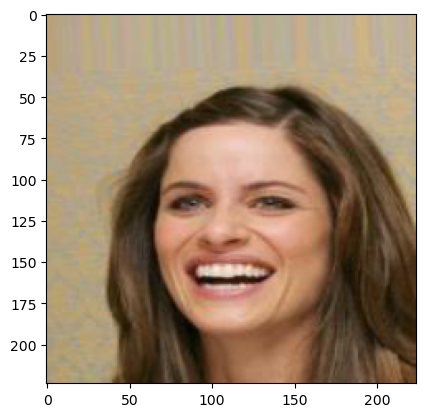

In [5]:
plt.imshow(dataloader.dataset[500][0].permute(1,2,0)) # viewing the image from data loader

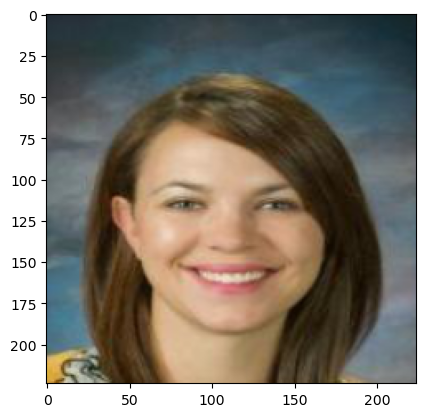

In [6]:
plt.imshow(valid_loader.dataset[0][0].permute(1,2,0)) #viewing an image from the validation loader

In [7]:
#Below is a custom neural  network, the decoder and encoder, note I have two decoders, to see which performs good,
#between upsampling and transposed convolutions"

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), #this is a convolution layer that takes an image with 3 channels(RGB), outputs 8 channel and has kernel size of 3X3
            nn.MaxPool2d(2, 2), #pooling summarizes feature space.
            nn.ReLU(inplace=True), 
            nn.Conv2d(8, 16, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 112, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(112, 128, 3, padding=1),
        )
        
        self.flattened_size = 128 * 28 * 28
        
        self.mean_layer = nn.Linear(self.flattened_size, 256)
        self.logvar_layer = nn.Linear(self.flattened_size, 256)  
        
    def forward(self, x): 
        out = self.block(x)
        out = torch.flatten(out, start_dim=1)
        mu = self.mean_layer(out)
        logvar = self.logvar_layer(out)
        return mu, logvar

        


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.flattened_size = 128 * 28 * 28
        self.fc1 = nn.Linear(256, self.flattened_size)
        
        self.block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 112, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(112, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.fc1(x)
        out = out.view(-1, 128, 28, 28)
        out = self.block(out)
        return out


class TransposedDecoder(nn.Module):
    def __init__(self):
        super(TransposedDecoder, self).__init__()
        self.flattened_size = 128 * 28 * 28
        self.fc1 = nn.Linear(256, self.flattened_size)

        self.block = nn.Sequential(
            nn.Conv2d(128, 112, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(112, 64, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding = 1),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(32, 16, 4, stride = 2, padding = 1),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(16, 8, 4, stride = 2, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(8, 3,3, padding = 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.fc1(x)
        out = out.view(-1, 128, 28, 28)
        out = self.block(out)
        return out


In [9]:
#skip this, but am basically creating a VAE, combining the class above into this network
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = TransposedDecoder()
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) 
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar
        
        
        

In [10]:
model = VAE() #model initialization.


In [11]:
#now here am checking if I have a GPU available(yes I do, because my PC has a GPU)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device #check output it says cuda(NVIDIA GPU software) if it was not available it would have said cpu

device(type='cuda')

In [163]:
model.to(device) #now here am loading my model to the GPU, remember training on CPU is not feasible, it will takes, i dont know, weeks train

VAE(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReLU(inplace=True)
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): ReLU(inplace=True)
      (11): Conv2d(64, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(112, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (mean_layer): Linear(in_features=100352, out_features=256, bias=

In [11]:
#this is the training loop
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train_vae(model, dataloader, epochs=15, beta = 1, optimizer=optimizer, learning_rate=0.001, valid_loader=valid_loader):
    

    valid_losses = []
    train_losses = []
    train_kl_losses = []
    valid_kl_losses = []
    train_recon_losses = []
    valid_recon_losses = []
    for epoch in range(epochs):
        train_loss = 0
        train_recon_loss = 0
        train_kl_loss = 0

        valid_loss = 0
        valid_kl_loss = 0
        valid_recon_loss = 0
        
        for images, _ in dataloader:
            images = images.to(device)
            optimizer.zero_grad()
            
            reconstructed, mu, logvar = model(images)
            
            recon_loss = F.mse_loss(reconstructed, images, reduction='sum')
            

            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            # Total loss
            loss = recon_loss + kl_loss*beta
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_recon_loss += recon_loss.item()
            train_kl_loss += kl_loss.item()

        model.eval()

        with torch.no_grad():
            for img, _ in valid_loader:
                img = img.to(device)
                reconstructed, mu, logvar = model(img)
                recon_loss = F.mse_loss(reconstructed, img, reduction='sum')
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + kl_loss*beta
                valid_loss += loss.item()
                valid_recon_loss += recon_loss.item()
                valid_kl_loss += kl_loss.item()
                
            
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss/len(dataloader):.4f}, valid loss: {valid_loss/len(valid_loader):.4f}")
        print(f"Train Recon Loss: {train_recon_loss/len(dataloader):.4f}, valid Recon Loss: {valid_recon_loss/len(valid_loader):.4f}")
        print(f"Train KL Loss: {train_kl_loss/len(dataloader):.4f}, valid Kl Loss: {valid_kl_loss/len(valid_loader):.4f}")

        train_losses.append(train_loss/len(dataloader))
        train_kl_losses.append(train_recon_loss/len(dataloader))
        train_recon_losses.append(train_kl_loss/len(dataloader))

        valid_losses.append(valid_loss/len(valid_loader))
        valid_recon_losses.append(valid_recon_loss/len(valid_loader))
        valid_kl_losses.append(valid_kl_loss/len(valid_loader))
    
    return model, optimizer, train_losses, train_kl_losses, train_recon_losses, valid_losses, valid_kl_losses, valid_recon_losses

In [12]:
#Loading the celeb face 224 by 224 model
checkpoint = torch.load("./vae_celebfaces_224.pth")
model.load_state_dict(checkpoint["model_state_dict"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/tmp/ipykernel_5424/1024199614.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./vae_celebfaces_224.pth")


VAE(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReLU(inplace=True)
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): ReLU(inplace=True)
      (11): Conv2d(64, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(112, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (mean_layer): Linear(in_features=100352, out_features=256, bias=

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [14]:
#running the training function, took approximately 5 hours to run this, with 3500 images.

model, optimizer, train_losses, train_kl_losses, train_recon_losses, valid_losses, valid_kl_losses, valid_recon_losses = train_vae(model, dataloader, beta = 1 ,epochs = 600, optimizer=optimizer)

Epoch 1/600
Train Loss: 6490.8222, valid loss: 26175.2811
Train Recon Loss: 3261.8313, valid Recon Loss: 24257.2227
Train KL Loss: 3228.9909, valid Kl Loss: 1918.0583
Epoch 2/600
Train Loss: 6476.5595, valid loss: 26258.5170
Train Recon Loss: 3253.1876, valid Recon Loss: 24339.4979
Train KL Loss: 3223.3719, valid Kl Loss: 1919.0191
Epoch 3/600
Train Loss: 6535.6746, valid loss: 26640.7487
Train Recon Loss: 3297.9030, valid Recon Loss: 24750.3996
Train KL Loss: 3237.7716, valid Kl Loss: 1890.3492
Epoch 4/600
Train Loss: 6518.7206, valid loss: 26795.6675
Train Recon Loss: 3293.1987, valid Recon Loss: 24918.4990
Train KL Loss: 3225.5219, valid Kl Loss: 1877.1686
Epoch 5/600
Train Loss: 6528.1441, valid loss: 26645.3902
Train Recon Loss: 3299.9773, valid Recon Loss: 24690.4734
Train KL Loss: 3228.1668, valid Kl Loss: 1954.9169
Epoch 6/600
Train Loss: 6562.4425, valid loss: 26639.3679
Train Recon Loss: 3322.7575, valid Recon Loss: 24692.5877
Train KL Loss: 3239.6849, valid Kl Loss: 1946.780

KeyboardInterrupt: 

In [18]:
#nvm
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [20]:
#the line below saves the model to your PC after training.
torch.save({"model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, "./vae_celebfaces_224.pth")

In [16]:
def generate_images(model, num_images=30, latent_dim=256):
    model.eval() 
    
    with torch.no_grad(): 
        z = torch.randn(num_images, latent_dim).to(device)
        
        generated_images = model.decoder(z)
        
    return generated_images
        

In [17]:
model_images = generate_images(model)

In [18]:
def generate(model, latent_dim):
    model_images = generate_images(model, latent_dim = latent_dim)
    for i in range(30):
        plt.imshow(model_images[i].to('cpu').permute(2,1,0))
        plt.show()

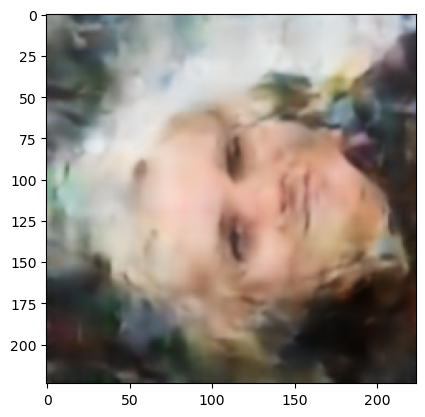

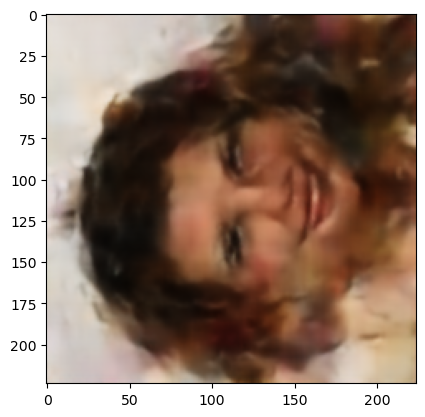

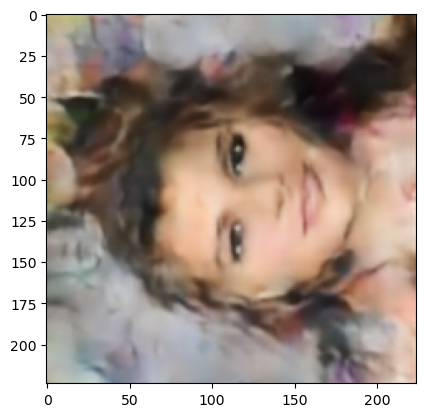

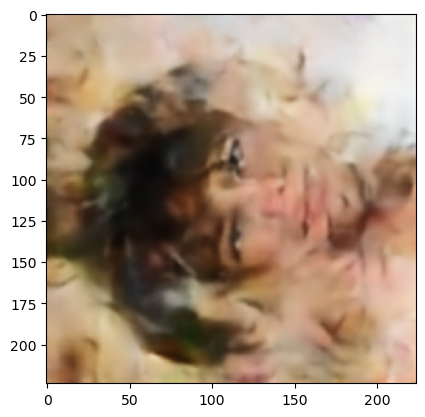

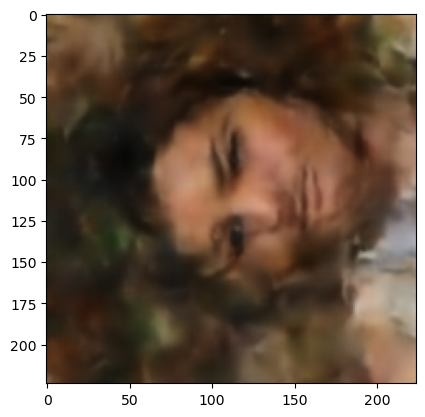

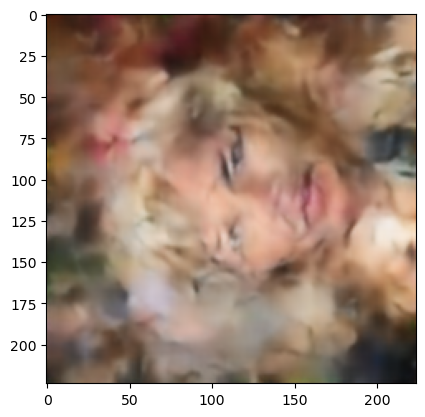

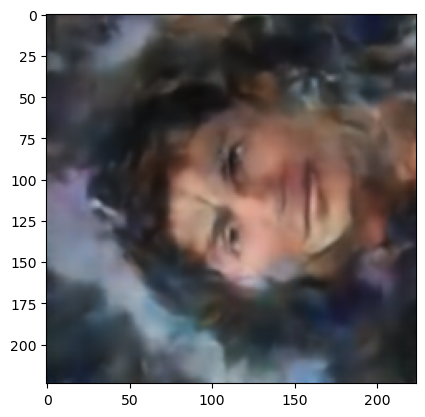

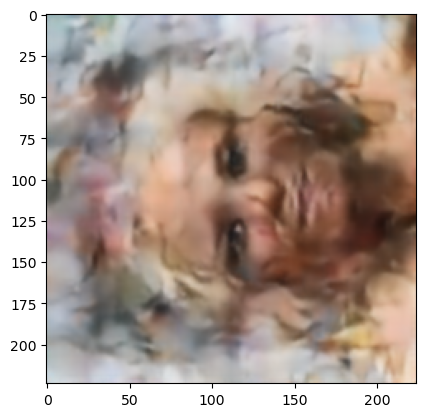

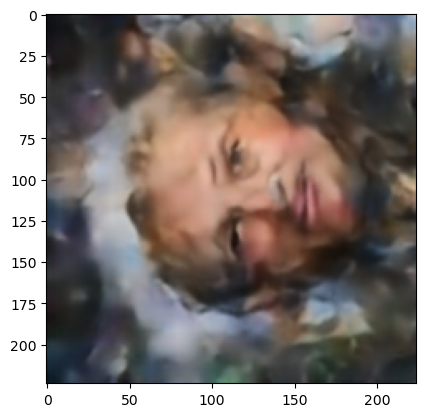

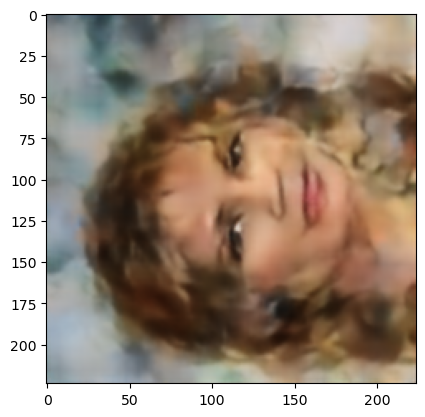

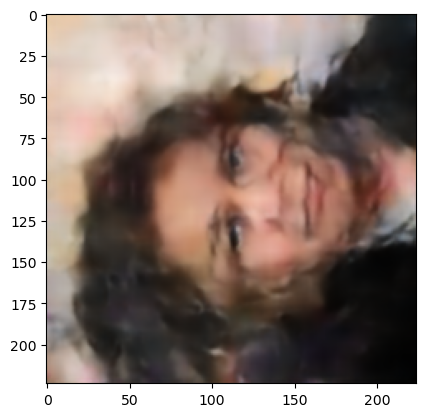

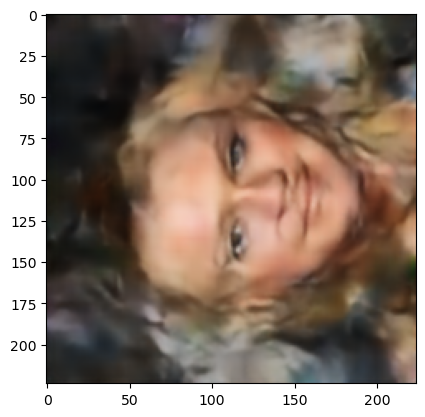

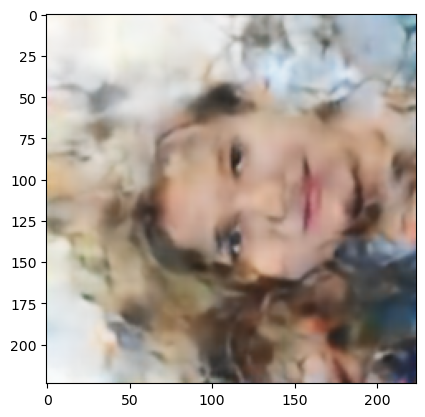

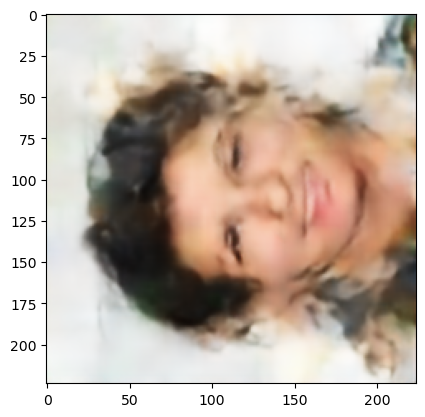

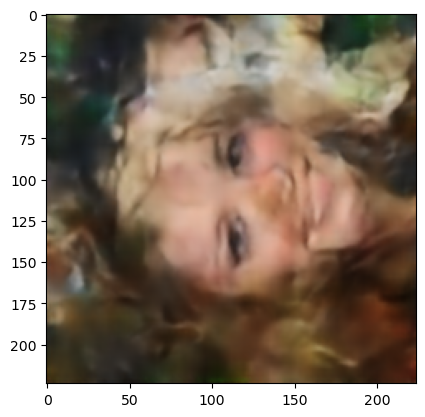

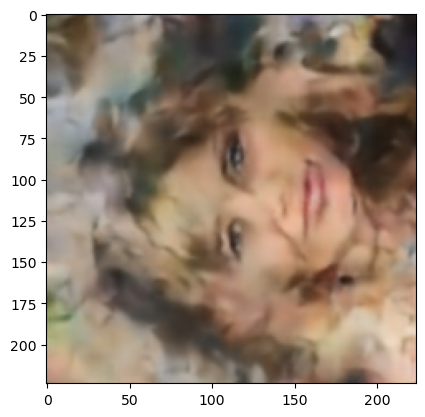

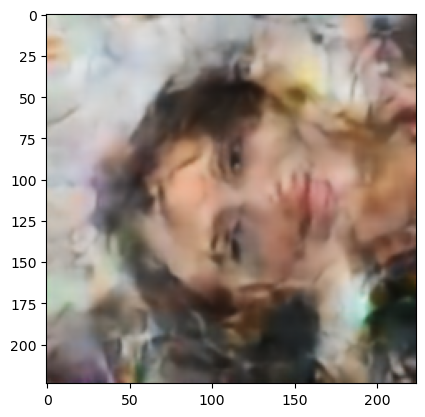

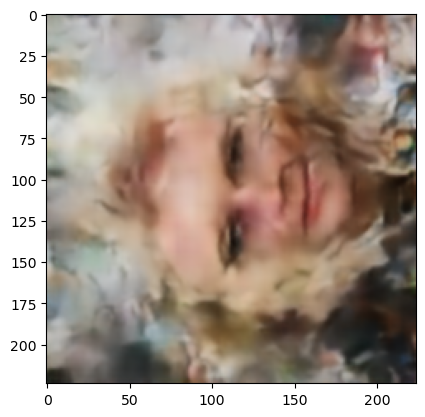

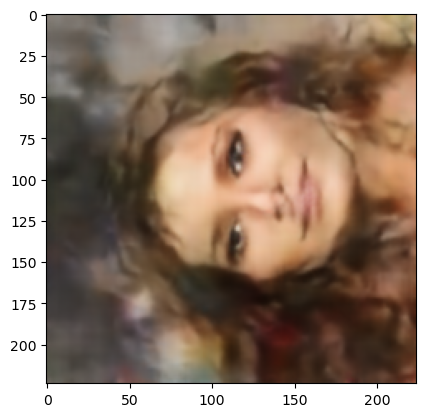

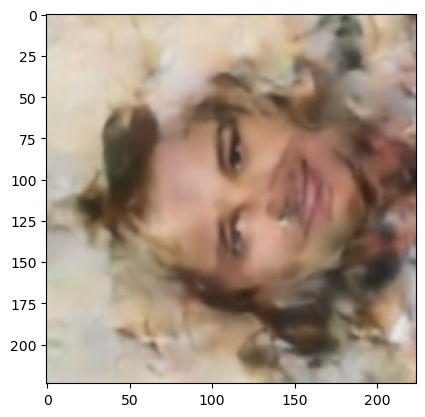

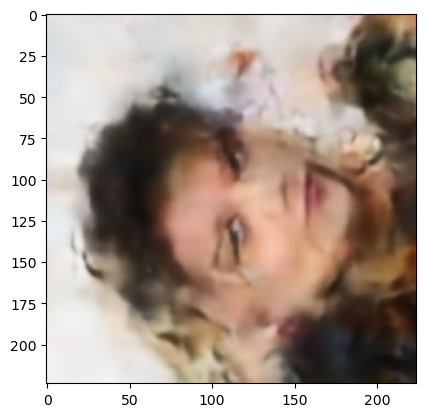

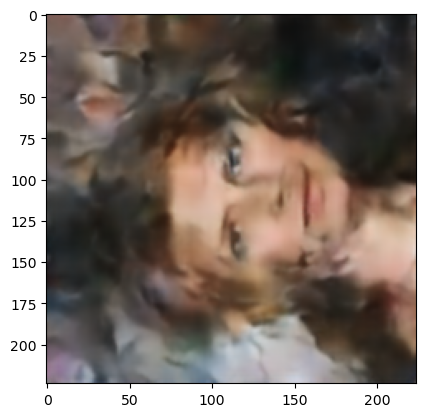

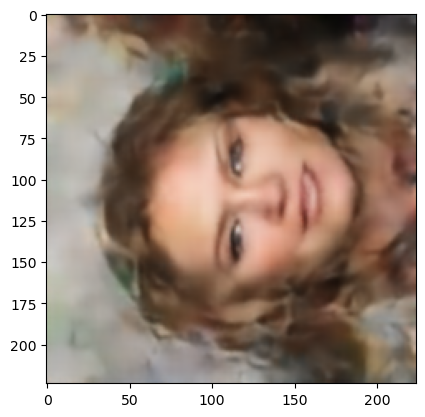

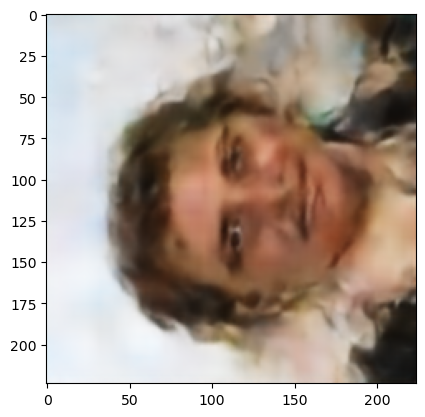

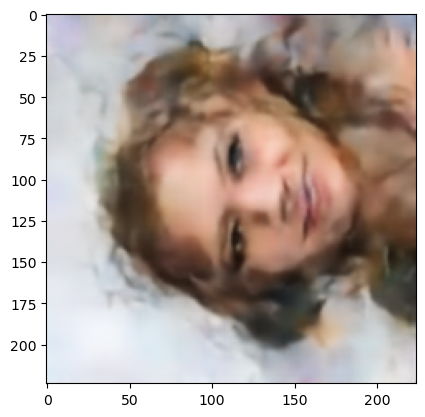

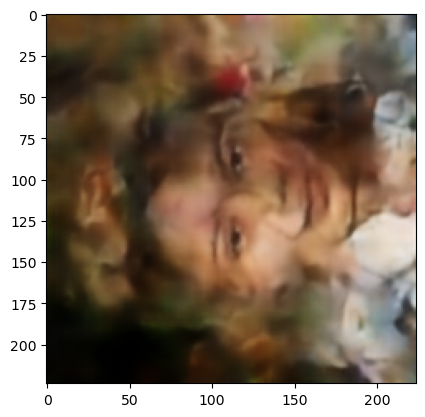

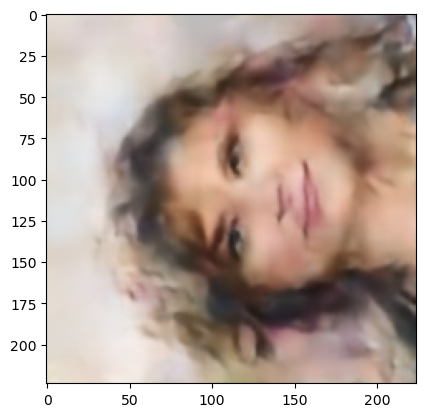

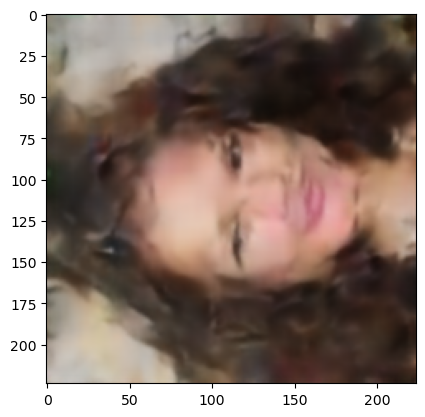

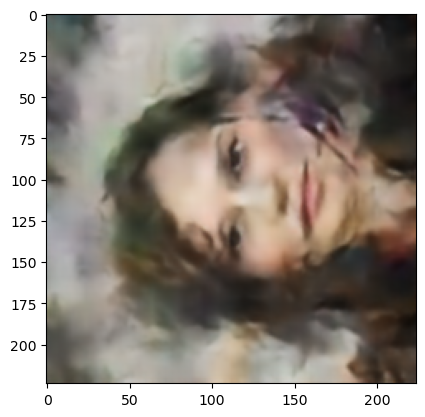

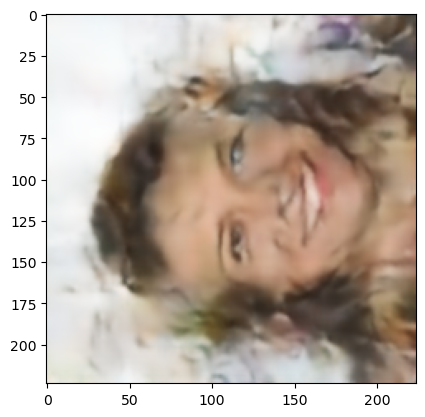

In [19]:
#generating images from a latent space, We do not use the encoder, we just sample from a normal distribution and generate
#the generated still lack, but not bad for a VAE.
for i in range(30):
    plt.imshow(model_images[i].to('cpu').permute(2,1,0))
    plt.show()

In [421]:
images = "./Faces_data/"
full_dataset = ImageFolder(images, transform= transform)
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

In [20]:
#Loading the celeb face 224 by 224 model
checkpoint = torch.load("./vae_celebfaces_224.pth")
model.load_state_dict(checkpoint["model_state_dict"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/tmp/ipykernel_5707/1024199614.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./vae_celebfaces_224.pth")


VAE(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReLU(inplace=True)
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): ReLU(inplace=True)
      (11): Conv2d(64, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(112, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (mean_layer): Linear(in_features=100352, out_features=256, bias=

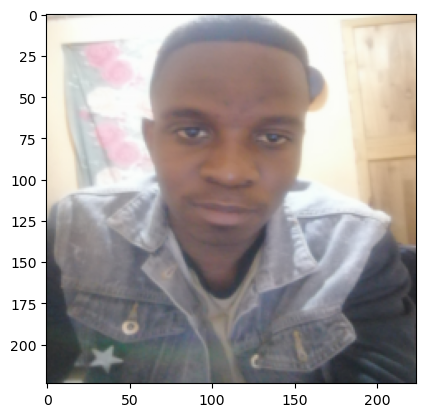

In [21]:
my_img = ImageFolder("./me/", transform=transform)
me_loader = DataLoader(my_img)
plt.imshow(me_loader.dataset[5][0].permute(1,2,0))

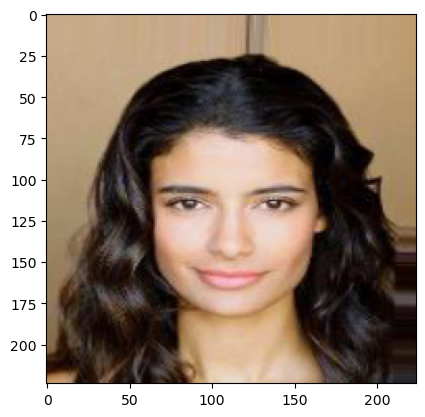

In [21]:
celeb_test_path = "./celeb_test/"
celeb_test_dataset = ImageFolder(celeb_test_path, transform=transform)
celeb_test_loader = DataLoader(celeb_test_dataset, batch_size=16)
plt.imshow(celeb_test_loader.dataset[109][0].permute(1,2,0))

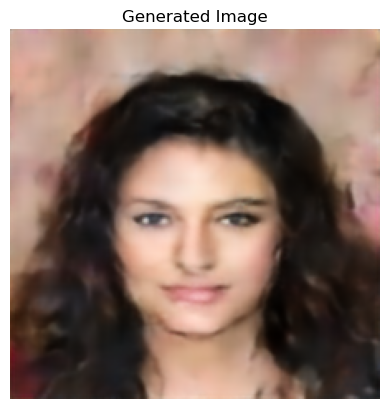

In [22]:
#feeding an  image to the encoder, get latent space and feed it to the decoder to get a new img
def generate_and_display_image(model, dataloader, device,k):
    model.eval()
    
    img = dataloader.dataset[k][0] 
    img = img.unsqueeze(0).to(device) 

    with torch.no_grad():
        mu, logvar = model.encoder(img)
        z = model.reparameterize(mu, logvar)
        generated = model.decoder(z) 
    
    gen_img = generated[0].cpu().numpy() 
    gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min()) 

    gen_img = gen_img.transpose(1, 2, 0)

    # Plot
    plt.imshow(gen_img)
    plt.title("Generated Image")
    plt.axis('off')
    plt.show()

generate_and_display_image(model, celeb_test_loader, device,k=109)

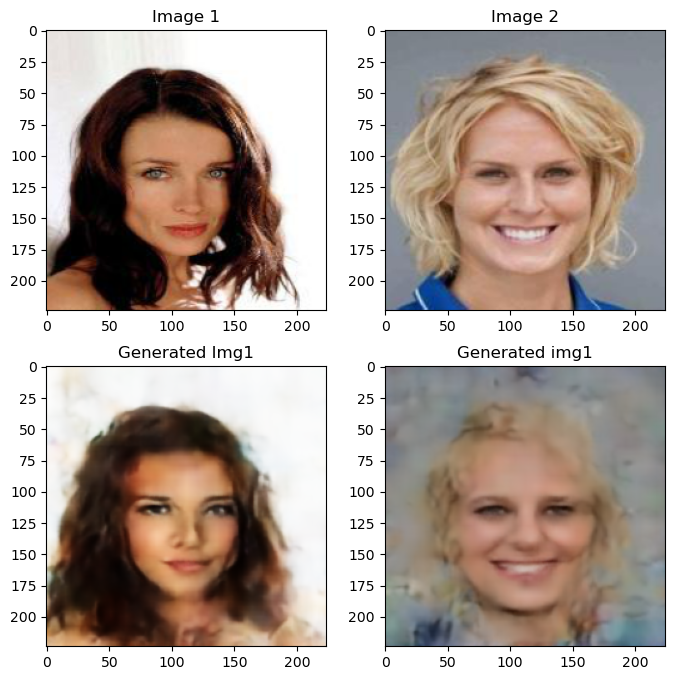

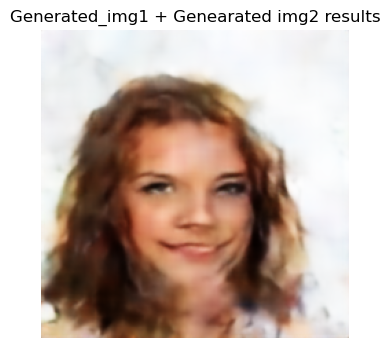

In [47]:
#performing arithmetic operation on latent spaces, add not smiling and smiling to get a smiling pic

def generate_addition(model, dataloader, device,k):
    model.eval()
    
    img_1 = dataloader.dataset[k][0] 
    img_1= img_1.unsqueeze(0).to(device) 

    img_2 = dataloader.dataset[k+1][0]
    img_2= img_2.unsqueeze(0).to(device) 

    with torch.no_grad():
        mu_1, logvar_1 = model.encoder(img_1)
        z_1 = model.reparameterize(mu_1, logvar_1)

        mu_2, logvar_2 = model.encoder(img_2)
        z_2 = model.reparameterize(mu_2, logvar_2)

        m = nn.ReLU()
        
        z = z_1+z_2
        #print(z)
        #z = m(z)
        #print(z)
        generated = model.decoder(z) 
        generated_img1 = model.decoder(z_1)
        generated_img2 = model.decoder(z_2)
    
    gen_img = generated[0].cpu().numpy() 
    gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min()) 

    gen_img1 = generated_img1[0].cpu().numpy() 
    gen_img1 = (gen_img1 - gen_img1.min()) / (gen_img.max() - gen_img.min()) 

    gen_img2 = generated_img2[0].cpu().numpy() 
    gen_img2 = (gen_img2 - gen_img2.min()) / (gen_img.max() - gen_img.min()) 
    
    gen_img = gen_img.transpose(1, 2, 0)

    # Plot

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))

    img_1 = img_1.unsqueeze(0).to('cpu')
    img_1 = img_1[0][0]
    ax[0,0].imshow(img_1.permute(1,2,0))
    ax[0,0].set_title("Image 1")


    img_2 = img_2.unsqueeze(0).to('cpu')
    img_2 = img_2[0][0]
    ax[0, 1].imshow(img_2.permute(1,2,0))
    ax[0, 1].set_title("Image 2")

    ax[1, 0].imshow(gen_img1.transpose(1,2,0))
    ax[1,0].set_title("Generated Img1")

    ax[1, 1].imshow(gen_img2.transpose(1,2,0))
    ax[1,1].set_title("Generated img1")

    plt.figure(figsize=(4, 4))
    plt.imshow(gen_img)
    plt.title("Generated_img1 + Genearated img2 results")
    plt.axis('off')
    plt.show()

    #ax[1, 2].imshow(gen_img)
    #ax[1, 2].set_title("results of adding Img1 + img2")

    return gen_img



gen_img = generate_addition(model, celeb_test_loader, device,k=250)